- This notebook runs the same hyperparameters settings as 6. Random Forest Model Creation, but drops the Topic column as a predictor variable and performs a Student's T-Test to determine whether the impact of Topic has a statistically significant impact on the performance of the model as evaluated on the cross-validation folds F1 scores.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from scipy.stats import ttest_ind

import h2o
from h2o.estimators import H2ORandomForestEstimator
%matplotlib inline
plt.style.use('ggplot')

# Loading Training and Test Datasets:

In [2]:
X_train = pd.read_csv('Datasets/X_train.csv')
X_test = pd.read_csv('Datasets/X_test.csv')
y_train = pd.read_csv('Datasets/y_train.csv')
y_test = pd.read_csv('Datasets/y_test.csv')

In [3]:
# Converting object columns and month/year (which are integers) to categorical columns:
list_to_convert = ['month_added', 'year_added', 'beer_style', 'beer_style_group']

for i in list_to_convert:
    X_train[i] = pd.Categorical(X_train[i])

In [4]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train['successful'] = pd.Categorical(Xy_train['successful'])

In [5]:
Xy_test = pd.concat([X_test, y_test], axis=1)
Xy_test['successful'] = pd.Categorical(Xy_test['successful'])

# The Model:


- I want to retain the beer_style and beer_style group columns wihout creating numerous dummy variables to save on memory usage when building the model.
- For that reason I cannot use scikit learn's implementation of random forests and instead am using the h2o implementation instead (http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html)

In [6]:
h2o.init(max_mem_size = "960M")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.271-b09, mixed mode, sharing)


C:\Users\rozhouse\Anaconda3\lib\site-packages\h2o\backend\server.py:385: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\Users\rozhouse\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\rozhouse\AppData\Local\Temp\tmp856_hqkc
  JVM stdout: C:\Users\rozhouse\AppData\Local\Temp\tmp856_hqkc\h2o_rozhouse_started_from_python.out
  JVM stderr: C:\Users\rozhouse\AppData\Local\Temp\tmp856_hqkc\h2o_rozhouse_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_rozhouse_9n66rz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,928 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [7]:
hf_train = h2o.H2OFrame(Xy_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
model = H2ORandomForestEstimator(ntrees=150, 
                                 max_depth=25, 
                                 nfolds=10,
                                seed = 42)

In [9]:
predictor_cols = ['beer_style', 'abv', 'num_ratings', 'beer_style_group', 'month_added', 
                  'year_added']
target_col = 'successful'

In [10]:
model.train(predictor_cols, target_col, training_frame = hf_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:
model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1605629296680_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,150.0,150.0,3188847.0,21.0,25.0,23.6,1087.0,1470.0,1252.88




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07754245151570754
RMSE: 0.27846445287631877
LogLoss: 0.32069122459985006
Mean Per-Class Error: 0.13655252560009679
AUC: 0.9352208585829621
AUCPR: 0.8273468455713472
Gini: 0.8704417171659242

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39061776042084795: 


,,No,Yes,Error,Rate
0,No,9744.0,856.0,0.0808,(856.0/10600.0)
1,Yes,645.0,2316.0,0.2178,(645.0/2961.0)
2,Total,10389.0,3172.0,0.1107,(1501.0/13561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,3.906178e-01,0.755258,207.0
1,max f2,1.826532e-01,0.812954,289.0
2,max f0point5,6.628136e-01,0.785039,116.0
3,max accuracy,4.951495e-01,0.894182,170.0
4,max precision,9.999792e-01,1.000000,0.0
5,max recall,3.318695e-07,1.000000,399.0
6,max specificity,9.999792e-01,1.000000,0.0
7,max absolute_mcc,4.403988e-01,0.686504,188.0
8,max min_per_class_accuracy,2.638887e-01,0.861533,255.0
9,max mean_per_class_accuracy,2.367659e-01,0.863447,266.0



Gains/Lift Table: Avg response rate: 21.83 %, avg score: 22.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010029,0.993967,4.512521,4.512521,0.985294,0.999187,0.985294,0.999187,0.045255,0.045255,351.252061,351.252061,0.045066
1,2,0.020058,0.973679,4.478845,4.495683,0.977941,0.981942,0.981618,0.990564,0.044917,0.090172,347.884508,349.568285,0.089701
2,3,0.030013,0.955383,4.376322,4.456091,0.955556,0.963744,0.972973,0.981668,0.043566,0.133739,337.632181,345.609135,0.132701
3,4,0.040115,0.937500,4.245574,4.403075,0.927007,0.946867,0.961397,0.972904,0.042891,0.176630,324.557446,340.307515,0.174648
4,5,0.050070,0.916724,4.206697,4.364031,0.918519,0.927580,0.952872,0.963893,0.041878,0.218507,320.669694,336.403088,0.215488
5,6,0.100066,0.787582,3.985434,4.174872,0.870206,0.854994,0.911570,0.909483,0.199257,0.417764,298.543404,317.487196,0.406444
6,7,0.150063,0.635291,3.377486,3.909207,0.737463,0.711871,0.853563,0.843645,0.168862,0.586626,237.748648,290.920741,0.558513
7,8,0.200059,0.479167,2.566890,3.573752,0.560472,0.555270,0.780317,0.771578,0.128335,0.714961,156.688972,257.375168,0.658735
8,9,0.300052,0.254717,1.516491,2.888167,0.331121,0.358369,0.630622,0.633876,0.151638,0.866599,51.649143,188.816680,0.724807
9,10,0.400560,0.120690,0.678748,2.333778,0.148202,0.178811,0.509573,0.519690,0.068220,0.934819,-32.125159,133.377849,0.683499




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.07778993776654047
RMSE: 0.2789084756090078
LogLoss: 0.27505368193170604
Mean Per-Class Error: 0.1386941561048345
AUC: 0.9363081697284829
AUCPR: 0.8272341249249526
Gini: 0.8726163394569657

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4175723712477418: 


,,No,Yes,Error,Rate
0,No,9826.0,774.0,0.073,(774.0/10600.0)
1,Yes,709.0,2252.0,0.2394,(709.0/2961.0)
2,Total,10535.0,3026.0,0.1094,(1483.0/13561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.417572,0.752297,201.0
1,max f2,0.180315,0.810762,294.0
2,max f0point5,0.594859,0.781559,142.0
3,max accuracy,0.481946,0.894698,178.0
4,max precision,0.959989,0.982609,15.0
5,max recall,0.000024,1.000000,399.0
6,max specificity,0.999584,0.999906,0.0
7,max absolute_mcc,0.457986,0.684197,186.0
8,max min_per_class_accuracy,0.265588,0.860182,258.0
9,max mean_per_class_accuracy,0.227829,0.861306,274.0



Gains/Lift Table: Avg response rate: 21.83 %, avg score: 22.03 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010397,0.986667,4.449946,4.449946,0.971631,0.993511,0.971631,0.993511,0.046268,0.046268,344.994623,344.994623,0.045891
1,2,0.020058,0.968531,4.509950,4.478845,0.984733,0.977170,0.977941,0.985641,0.043566,0.089835,350.994996,347.884508,0.089268
2,3,0.030013,0.949575,4.444172,4.467344,0.970370,0.959061,0.975430,0.976824,0.044242,0.134076,344.417176,346.734411,0.133133
3,4,0.040041,0.930390,4.310467,4.428053,0.941176,0.939720,0.966851,0.967531,0.043229,0.177305,331.046745,342.805271,0.175607
4,5,0.050070,0.907778,4.276792,4.397756,0.933824,0.919251,0.960236,0.957861,0.042891,0.220196,327.679192,339.775600,0.217649
5,6,0.100066,0.774684,3.938149,4.168122,0.859882,0.846237,0.910096,0.902090,0.196893,0.417089,293.814923,316.812196,0.405579
6,7,0.150063,0.626389,3.336957,3.891203,0.728614,0.701748,0.849631,0.835342,0.166836,0.583924,233.695664,289.120300,0.555056
7,8,0.200059,0.475238,2.668214,3.585569,0.582596,0.550870,0.782897,0.764250,0.133401,0.717325,166.821432,258.556853,0.661759
8,9,0.300052,0.257778,1.442187,2.871284,0.314897,0.357931,0.626935,0.628844,0.144208,0.861533,44.218673,187.128351,0.718326
9,10,0.400044,0.119914,0.743047,2.339322,0.162242,0.181642,0.510783,0.517064,0.074299,0.935832,-25.695297,133.932247,0.685455




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.8934823,0.010787609,0.8891386,0.87172014,0.8929088,0.8997093,0.8962045,0.9050633,0.8968313,0.90849674,0.8929889,0.88176197
1,auc,0.9364456,0.007493543,0.9430724,0.92500275,0.93517137,0.92988306,0.9385559,0.9264582,0.93870044,0.94861674,0.9372856,0.94170934
2,aucpr,0.82768345,0.023346514,0.8535349,0.80530417,0.8145731,0.81414574,0.8406255,0.78512096,0.82704455,0.8624252,0.8401981,0.83386225
3,err,0.10651765,0.010787609,0.11086142,0.12827988,0.10709117,0.1002907,0.103795506,0.094936706,0.103168756,0.09150327,0.10701107,0.118238024
4,err_count,144.3,13.719815,148.0,176.0,148.0,138.0,134.0,135.0,140.0,126.0,145.0,153.0
5,f0point5,0.7534289,0.03280868,0.7832122,0.7036613,0.76147425,0.7406166,0.7649897,0.7423756,0.75048107,0.81632656,0.76044387,0.7107076
6,f1,0.75966346,0.021129258,0.7620579,0.73652697,0.7474403,0.762069,0.76816607,0.7326733,0.7697368,0.80733943,0.7626841,0.7479407
7,f2,0.7670718,0.025881305,0.74201626,0.77261305,0.7339142,0.7848011,0.771369,0.72322124,0.79000676,0.7985481,0.76493764,0.78929067
8,lift_top_group,4.4819045,0.49114338,3.8142858,4.1363635,4.576159,4.985507,4.4982576,5.5116277,4.3301425,4.135135,4.1600876,4.67148
9,logloss,0.27475148,0.021253262,0.27703872,0.2840062,0.2799129,0.27906522,0.25211477,0.2892421,0.31487158,0.24858628,0.27796277,0.24471436



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-11-17 16:08:53,17.376 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-17 16:08:53,17.396 sec,1.0,0.404593,5.567740,0.770794,0.523114,2.858851,0.163981
2,,2020-11-17 16:08:53,17.416 sec,2.0,0.386017,4.711110,0.788681,0.551025,2.997164,0.163993
3,,2020-11-17 16:08:53,17.443 sec,3.0,0.376198,4.210399,0.801750,0.564748,3.045740,0.163360
4,,2020-11-17 16:08:53,17.465 sec,4.0,0.362883,3.597584,0.817941,0.590925,3.171642,0.159545
5,,2020-11-17 16:08:53,17.488 sec,5.0,0.352638,3.080126,0.830762,0.616526,3.313656,0.157539
6,,2020-11-17 16:08:53,17.510 sec,6.0,0.343231,2.678944,0.842205,0.637813,3.421549,0.153176
7,,2020-11-17 16:08:53,17.532 sec,7.0,0.336235,2.360955,0.852808,0.655771,3.513122,0.150679
8,,2020-11-17 16:08:53,17.558 sec,8.0,0.330748,2.143494,0.860134,0.670928,3.586155,0.146874
9,,2020-11-17 16:08:53,17.579 sec,9.0,0.325039,1.917856,0.867343,0.686175,3.668675,0.143531



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,beer_style,85272.273438,1.000000,0.360429
1,abv,55290.050781,0.648394,0.233700
2,num_ratings,47696.039062,0.559338,0.201602
3,beer_style_group,17040.296875,0.199834,0.072026
4,month_added,16534.453125,0.193902,0.069888
5,year_added,14752.311523,0.173002,0.062355


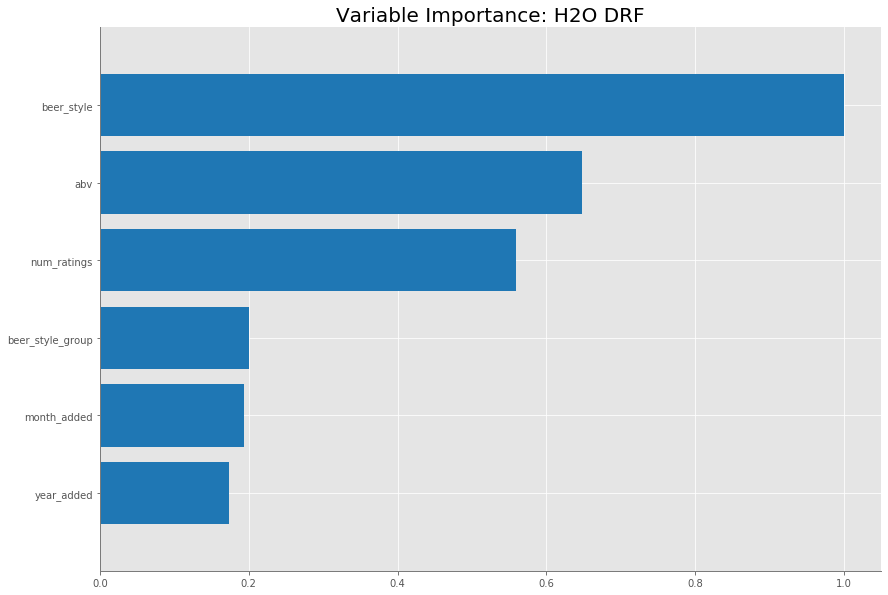

In [15]:
model.varimp_plot()

plt.show()

In [24]:
w_o_topics_data_train_f1 = [0.7620579, 0.73652697, 0.7474403, 0.762069, 0.76816607, 0.7326733, 
                            0.76973680, 0.80733943, 0.7626841, 0.7479407]

In [25]:
full_data_train_f1 = [0.745679, 0.7677165, 0.75243664, 0.76095617, 
                      0.74883723, 0.8, 0.7651822, 0.7868217, 0.7467811, 0.7399103]

In [26]:
print(mean(w_o_topics_data_train_f1))
print(mean(full_data_train_f1))

0.759663457
0.761432084


# Applying Student's T-Test to Ascertain whether there are significant differences in terms of f1-score between the two models:

In [20]:
stat, p = ttest_ind(full_data_train_f1, w_o_topics_data_train_f1)

In [33]:
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Same distributions (fail to reject H0)


- As expected based on the average F1 score above, the T-Test reports that H0 cannot be rejected and adding Topics does not make a significant difference to the performance of the model.

- Despite this some of the exploratory work done does show significant differences between the two target categories in terms of tasting notes and it may be the case that topics are an extension of trends represented by the ABV and beer style variables.

- I will explore how plotting data using the topics categories can inform our understanding of the dataset in the Notebook 7.